## Clinical Application 
### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

Before running the script, the CAST dataset needs to be downloaded by running     
`git clone https://github.com/udacity/nd320-c4-wearable-data-project-starter/tree/master/part_2/datasets/crisdb`. 

-----

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `./datasets/crisdb/`

In [2]:
hr_filenames = sorted(glob.glob("./datasets/crisdb/*.npz"))
len(hr_filenames)

1537

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [3]:
metadata_filename = './datasets/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


In [4]:
metadata.shape

(1543, 3)

### EDA

In [5]:
metadata.subject.nunique()

1543

In [6]:
metadata.sex.value_counts()

Male      1266
Female     277
Name: sex, dtype: int64

In [31]:
(metadata.sex == 'Female').sum() / (metadata.sex == 'Male').sum()

0.21879936808846762

In [8]:
metadata.age.value_counts()

60-64    313
65-69    291
55-59    261
70-74    196
50-54    164
45-49    124
75-79     98
40-44     62
35-39     28
30-34      4
20-24      2
Name: age, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

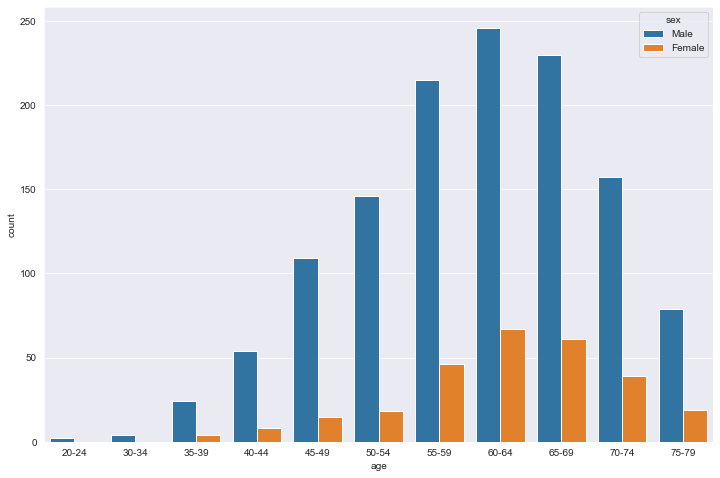

In [26]:
plt.figure(figsize=(12,8))
sns.countplot(x='age', hue='sex', data=metadata)

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [11]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.split(filename)[1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata.subject==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata.subject==subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [12]:
df.shape

(1537, 3)

#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

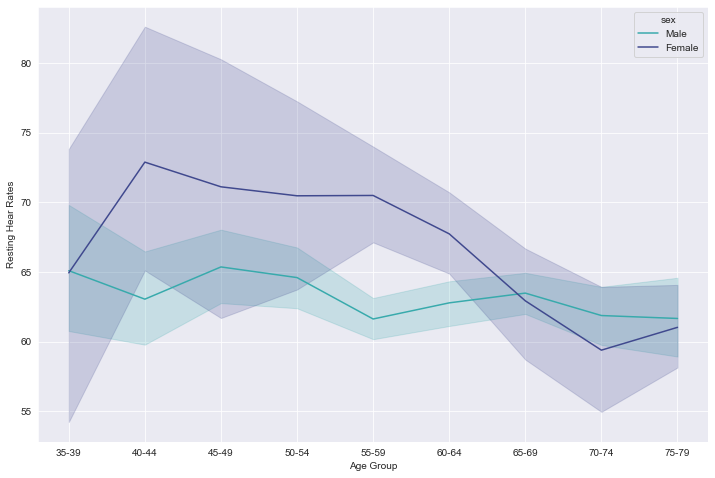

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

palette = sns.color_palette("mako_r", 2)

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
g = sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df, palette=palette)
g.set(xlabel='Age Group', ylabel='Resting Hear Rates')
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
1. For women, we see that the peak resting heart rates (RHR) appears at age 40-44, and the lowest RHR at age 70-74. The steepest increase seems to happen from ages 35-39 to 40-44. And a relatively large increase in confidence interval took place at the transition from ages 40-44 to ages 45-49. The confidence interval indicates that the BPM ranges from 55 BPM to 85 BPM. 

2. For men, we see that the fluctuation in RHR is relatively smaller when compared with the pattern observed among women. There is a slight decrease in RHR at ages 70-74. 

3. In comparison to men, women's heart rate is more fluctuating and falls into a wider range. Women seem to have higher heart rates than men from the age groups range from 40 till 65. The overall confidence interval around women's average heart rate is also wider when compared with men. 

4. What are some possible reasons for what we see in our data?    
Females heart sizes is typically smaller than the ones of males', which may lead to a faster heart rate to pump up blood supplies. 
Moreover, the ratio of female subjects to male is 1:4, which is a quite unbalanced dataset. The small sample size may result in more variations and greater deviations, such as unbalanced representation of female groups. 

5. What else can we do or go and find to figure out what is really happening? How would that improve the results?    
One thing we can do is to get more female subjects involved to balance the dataset. Moreover, it's critical to have a diversified demographic representation in the dataset, such that we can avoid having biased data. Additionally, this dataset comes from CAST, which were collected from people who have had a heart attack within the past two years. We can look into the health condition/records of these participates to see if there's a correlation between their health condition and the variation of heart rates. Lastly, lifestyle such as diet and workout can also affect resting heart rates, and it may be useful to do a survey among the subjects to analyze if lifestyle can be a potential factor. 

6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How? 
Based on the age distribution of the dataset, we do not have enough evidence to validate the trend, because the young age groups (age below 30-year-old) are missing in the dataset. The dataset is unbalanced in terms of age groups too. 